In [ ]:
# Import necessary libraries
import sys, os, glob, time, imageio
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image

import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [ ]:
# Root directory for dataset
google_drive_root = '/Users/adityadwivedi/Downloads/chest_xray'  # Replace with your folder structure
dataroot_train = os.path.join(google_drive_root, 'chest_xray', 'train')
dataroot_test = os.path.join(google_drive_root, 'chest_xray', 'test')
dataroot_val = os.path.join(google_drive_root, 'chest_xray', 'val')

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For grayscale images this is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Size of feature maps in encoder
nef = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0


Image has 1 channel


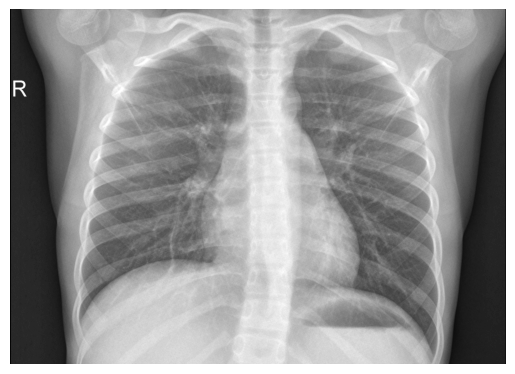

In [ ]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

from PIL import Image
import numpy as np
import os

# Update filename with the path in Google Drive
filename = '/Users/adityadwivedi/Downloads/chest_xray/test/NORMAL/IM-0003-0001.jpeg'  # Replace with your folder structure

# Check if the file exists
if not os.path.exists(filename):
    raise FileNotFoundError(f"File not found: {filename}")

# Open image using PIL
im = Image.open(filename)
im.show()

# Convert to numpy array
img = np.array(im)

# Find number of channels
if img.ndim == 2:
    channels = 1
    print("Image has 1 channel")
else:
    channels = img.shape[-1]  # Corrected from 'image' to 'img'
    print("Image has", channels, "channels")

# Display the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename), cmap='gray' if channels == 1 else None)
plt.axis('off')
plt.show()


In [ ]:
# Define the datasets
dataset_train = dset.ImageFolder(root=dataroot_train,
                                 is_valid_file=check_Image,
                                 transform=transforms.Compose([
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,)),
                                 ]))

dataset_test = dset.ImageFolder(root=dataroot_test,
                                is_valid_file=check_Image,
                                transform=transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                ]))

dataset_val = dset.ImageFolder(root=dataroot_val,
                               is_valid_file=check_Image,
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,)),
                               ]))

# Combine datasets
combined_datasets = torch.utils.data.ConcatDataset([dataset_train, dataset_test, dataset_val])

# Create dataloader
dataloader = torch.utils.data.DataLoader(combined_datasets, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


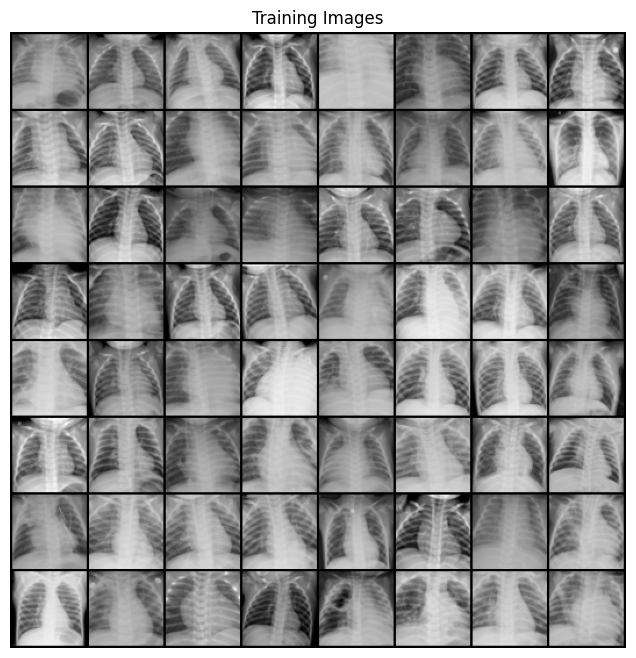

In [ ]:
# Visualize some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')
plt.show()


In [ ]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
# VAE Encoder
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, nef, 4, 2, 1, bias=False),  # (nef) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False),  # (nef*2) x 16 x 16
            nn.BatchNorm2d(nef * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nef * 2, nef * 4, 4, 2, 1, bias=False),  # (nef*4) x 8 x 8
            nn.BatchNorm2d(nef * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nef * 4, nef * 8, 4, 2, 1, bias=False),  # (nef*8) x 4 x 4
            nn.BatchNorm2d(nef * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Linear layers for mean and log variance
        self.fc_mu = nn.Linear(nef * 8 * 4 * 4, nz)
        self.fc_logvar = nn.Linear(nef * 8 * 4 * 4, nz)

    def forward(self, input):
        x = self.main(input)  # (batch_size, nef*8, 4,4)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)  # (batch_size, nz)
        logvar = self.fc_logvar(x)  # (batch_size, nz)
        return mu, logvar


In [ ]:
# Reparameterization Trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)  # Calculate standard deviation
    eps = torch.randn_like(std)    # Sample epsilon from standard normal
    return mu + eps * std          # Return sampled latent vector


In [ ]:
# VAE-DCGAN Generator (Decoder)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z latent vector (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # (ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),      # (ngf) x 32 x 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),          # (nc) x 64 x 64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# VAE-DCGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # (ndf) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # (ndf*2) x 16 x 16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # (ndf*8) x 4 x 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),        # Output: 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [ ]:
# VAE-DCGAN Combined Model
class VAE_DCGAN(nn.Module):
    def __init__(self, nc, nef, ngf, ndf, nz):
        super(VAE_DCGAN, self).__init__()
        self.encoder = Encoder(nc, nef, nz)
        self.generator = Generator(nz, ngf, nc)
        self.discriminator = Discriminator(nc, ndf)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        fake = self.generator(z.unsqueeze(2).unsqueeze(3))  # Reshape z to (batch, nz, 1,1)
        disc_fake = self.discriminator(fake)
        disc_real = self.discriminator(x)
        return mu, logvar, fake, disc_real, disc_fake


In [ ]:
# Define constants for VAE-DCGAN
SIZE_OF_NOISE = 100
SIZE_OF_FEATURE_MAP = 64
NUM_CHANNELS = 1
SIZE_OF_ENCODER_FEATURE_MAP = 64

# Create the VAE-DCGAN model
netVAE_DCGAN = VAE_DCGAN(nc=NUM_CHANNELS, nef=SIZE_OF_ENCODER_FEATURE_MAP, ngf=SIZE_OF_FEATURE_MAP, ndf=SIZE_OF_FEATURE_MAP, nz=SIZE_OF_NOISE).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netVAE_DCGAN = nn.DataParallel(netVAE_DCGAN, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netVAE_DCGAN.apply(weights_init)

# Print the VAE-DCGAN model
print(netVAE_DCGAN)


VAE_DCGAN(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (fc_mu): Linear(in_features=8192, out_features=100, bias=True)
    (fc_logva

In [ ]:
# Loss functions
criterion_GAN = nn.BCELoss()          # Adversarial loss
criterion_recon = nn.MSELoss()        # Reconstruction loss
criterion_KL = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Optimizers
optimizer = optim.Adam(netVAE_DCGAN.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torch_fidelity import calculate_metrics

# Function to compute PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Function to compute SSIM
def calculate_ssim(img1, img2):
    img1 = img1.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to Numpy (BCHW to BHWC)
    img2 = img2.cpu().numpy().transpose(0, 2, 3, 1)

    ssim_values = []
    for i in range(img1.shape[0]):
        height, width, _ = img1[i].shape
        min_dim = min(height, width)
        win_size = min(7, min_dim) if min_dim >= 3 else 3  # Ensure a minimum of 3x3 window

        ssim_val = ssim(
            img1[i],
            img2[i],
            win_size=win_size,
            data_range=1.0,   # Assuming pixel values are normalized to [0, 1]
            channel_axis=-1   # Explicitly set the axis for color channels
        )
        ssim_values.append(ssim_val)

    return np.mean(ssim_values)

# Function to compute FID
def calculate_fid_score(real_images, fake_images):
    """
    Calculate the FID score between real and fake images using torch_fidelity.

    Parameters:
        real_images (torch.Tensor): Real images (B, C, H, W) normalized to [0, 1].
        fake_images (torch.Tensor): Fake images (B, C, H, W) normalized to [0, 1].

    Returns:
        float: The FID score.
    """
    real_images = (real_images * 255).byte()  # Convert to [0, 255] range
    fake_images = (fake_images * 255).byte()

    # Save real and fake images as temporary folders
    import tempfile
    from torchvision.utils import save_image

    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:
        # Save images to their respective folders
        for i, img in enumerate(real_images):
            save_image(img.float() / 255.0, f"{real_dir}/real_{i}.png")
        for i, img in enumerate(fake_images):
            save_image(img.float() / 255.0, f"{fake_dir}/fake_{i}.png")

        # Calculate FID using the saved folders
        metrics = calculate_metrics(
            input1=real_dir,
            input2=fake_dir,
            cuda=torch.cuda.is_available(),
            fid=True  # Enable FID computation
        )
    return metrics["frechet_inception_distance"]


In [ ]:
torch.autograd.set_detect_anomaly(True)

# Initialize lists to track metrics
fid_scores = []
psnr_scores = []
ssim_scores = []

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Define separate optimizers
optimizer_D = optim.Adam(netVAE_DCGAN.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(list(netVAE_DCGAN.generator.parameters()) + list(netVAE_DCGAN.encoder.parameters()), lr=lr, betas=(beta1, 0.999))

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        netVAE_DCGAN.discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output_real = netVAE_DCGAN.discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        loss_D_real = criterion_GAN(output_real, label_real)
        # Calculate gradients for D in backward pass
        loss_D_real.backward()
        D_x = output_real.mean().item()

        ## Train with all-fake batch
        # Encode real images to latent space
        mu, logvar = netVAE_DCGAN.encoder(real_cpu)
        z = reparameterize(mu, logvar)
        fake = netVAE_DCGAN.generator(z.unsqueeze(2).unsqueeze(3))
        label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with D
        output_fake = netVAE_DCGAN.discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        loss_D_fake = criterion_GAN(output_fake, label_fake)
        # Calculate the gradients for this batch, accumulated with previous gradients
        loss_D_fake.backward()
        D_G_z1 = output_fake.mean().item()
        # Compute error of D as sum over the fake and the real batches
        loss_D = loss_D_real + loss_D_fake
        # Update D
        optimizer_D.step()

        ############################
        # (2) Update Generator and Encoder
        ###########################
        netVAE_DCGAN.generator.zero_grad()
        netVAE_DCGAN.encoder.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output_fake = netVAE_DCGAN.discriminator(fake).view(-1)
        # Calculate G's adversarial loss based on this output
        loss_G_GAN = criterion_GAN(output_fake, label_real)
        # Calculate VAE's reconstruction loss
        loss_G_recon = criterion_recon(fake, real_cpu)
        # Calculate VAE's KL divergence loss
        loss_G_KL = criterion_KL(mu, logvar)
        # Total generator loss
        loss_G = loss_G_GAN + loss_G_recon + loss_G_KL
        # Calculate gradients for G and Encoder
        loss_G.backward()
        D_G_z2 = output_fake.mean().item()
        # Update G and Encoder
        optimizer_G.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netVAE_DCGAN.generator(fixed_noise).detach().cpu()
                real_images = data[0].cpu()

            min_batch_size = min(real_images.size(0), fake.size(0))
            real_images = real_images[:min_batch_size]
            fake = fake[:min_batch_size]
            # Calculate PSNR
            psnr_score = calculate_psnr(real_images, fake)
            psnr_scores.append(psnr_score)

            # Calculate SSIM
            ssim_score = calculate_ssim(real_images, fake)
            ssim_scores.append(ssim_score)

            # Calculate FID
            fid_score = calculate_fid_score(real_images, fake)
            fid_scores.append(fid_score)

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/50][0/92]	Loss_D: 1.6658	Loss_G: 830.3951	D(x): 0.7263	D(G(z)): 0.6345 / 0.0024


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmp8sh6hm7s" with extensions png,jpg,jpeg
Found 64 samples
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and Un

[0/50][50/92]	Loss_D: 1.8230	Loss_G: 81.7238	D(x): 0.9531	D(G(z)): 0.6033 / 0.0000
[1/50][0/92]	Loss_D: 0.2321	Loss_G: 31.7509	D(x): 0.8768	D(G(z)): 0.0577 / 0.0235
[1/50][50/92]	Loss_D: 0.1996	Loss_G: 57.3809	D(x): 0.9208	D(G(z)): 0.1017 / 0.0172
[2/50][0/92]	Loss_D: 0.4281	Loss_G: 23.7177	D(x): 0.9735	D(G(z)): 0.2840 / 0.0102
[2/50][50/92]	Loss_D: 0.5988	Loss_G: 32.4069	D(x): 0.6863	D(G(z)): 0.0386 / 0.0545
[3/50][0/92]	Loss_D: 1.1890	Loss_G: 24.0493	D(x): 0.9295	D(G(z)): 0.5746 / 0.0033
[3/50][50/92]	Loss_D: 0.7430	Loss_G: 21.2953	D(x): 0.9172	D(G(z)): 0.4108 / 0.0049
[4/50][0/92]	Loss_D: 0.4656	Loss_G: 13.9450	D(x): 0.8500	D(G(z)): 0.2121 / 0.0140
[4/50][50/92]	Loss_D: 0.4900	Loss_G: 23.6106	D(x): 0.9343	D(G(z)): 0.2914 / 0.0178
[5/50][0/92]	Loss_D: 0.5920	Loss_G: 18.3361	D(x): 0.9623	D(G(z)): 0.3627 / 0.0068


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpbisu11my" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[5/50][50/92]	Loss_D: 0.4125	Loss_G: 47.2400	D(x): 0.8855	D(G(z)): 0.2161 / 0.0221
[6/50][0/92]	Loss_D: 0.8790	Loss_G: 12.7344	D(x): 0.5311	D(G(z)): 0.0176 / 0.0692
[6/50][50/92]	Loss_D: 0.2765	Loss_G: 16.4183	D(x): 0.9293	D(G(z)): 0.1569 / 0.0224
[7/50][0/92]	Loss_D: 0.3866	Loss_G: 11.3829	D(x): 0.9223	D(G(z)): 0.1915 / 0.0175
[7/50][50/92]	Loss_D: 0.6553	Loss_G: 22.1306	D(x): 0.9333	D(G(z)): 0.3454 / 0.0131
[8/50][0/92]	Loss_D: 0.6720	Loss_G: 10.0841	D(x): 0.6097	D(G(z)): 0.0360 / 0.0646
[8/50][50/92]	Loss_D: 0.3650	Loss_G: 17.6408	D(x): 0.7841	D(G(z)): 0.0647 / 0.0586
[9/50][0/92]	Loss_D: 0.2300	Loss_G: 14.2935	D(x): 0.8825	D(G(z)): 0.0678 / 0.0152
[9/50][50/92]	Loss_D: 0.5233	Loss_G: 15.6661	D(x): 0.8252	D(G(z)): 0.2236 / 0.0201
[10/50][0/92]	Loss_D: 0.3456	Loss_G: 9.1530	D(x): 0.8022	D(G(z)): 0.0771 / 0.0375
[10/50][50/92]	Loss_D: 0.5042	Loss_G: 66.8373	D(x): 0.7458	D(G(z)): 0.0314 / 0.0171


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpv2cy1lev" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[11/50][0/92]	Loss_D: 0.6962	Loss_G: 10.2356	D(x): 0.9385	D(G(z)): 0.3788 / 0.0239
[11/50][50/92]	Loss_D: 0.2433	Loss_G: 163.2267	D(x): 0.8825	D(G(z)): 0.0918 / 0.0247
[12/50][0/92]	Loss_D: 0.8800	Loss_G: 80.0199	D(x): 0.9757	D(G(z)): 0.4695 / 0.0002
[12/50][50/92]	Loss_D: 0.2890	Loss_G: 24.0080	D(x): 0.8321	D(G(z)): 0.0507 / 0.0228
[13/50][0/92]	Loss_D: 0.4856	Loss_G: 30.6473	D(x): 0.9634	D(G(z)): 0.3221 / 0.0051
[13/50][50/92]	Loss_D: 0.3362	Loss_G: 12.3583	D(x): 0.8176	D(G(z)): 0.0540 / 0.0604
[14/50][0/92]	Loss_D: 0.6179	Loss_G: 22.5655	D(x): 0.9230	D(G(z)): 0.3566 / 0.0003
[14/50][50/92]	Loss_D: 0.6327	Loss_G: 12.2312	D(x): 0.6524	D(G(z)): 0.0220 / 0.0736
[15/50][0/92]	Loss_D: 0.2763	Loss_G: 13.6538	D(x): 0.9007	D(G(z)): 0.1369 / 0.0052
[15/50][50/92]	Loss_D: 0.3969	Loss_G: 22.2040	D(x): 0.7889	D(G(z)): 0.0328 / 0.0070
[16/50][0/92]	Loss_D: 0.5867	Loss_G: 10.8218	D(x): 0.6658	D(G(z)): 0.0118 / 0.0431


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpa61fm9iu" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[16/50][50/92]	Loss_D: 0.3437	Loss_G: 10.5208	D(x): 0.8002	D(G(z)): 0.0182 / 0.0122
[17/50][0/92]	Loss_D: 0.3980	Loss_G: 10.6316	D(x): 0.9755	D(G(z)): 0.2482 / 0.0053
[17/50][50/92]	Loss_D: 0.2587	Loss_G: 9.0308	D(x): 0.9529	D(G(z)): 0.1690 / 0.0122
[18/50][0/92]	Loss_D: 0.3020	Loss_G: 11.0357	D(x): 0.7949	D(G(z)): 0.0090 / 0.0088
[18/50][50/92]	Loss_D: 0.6001	Loss_G: 12.6158	D(x): 0.9529	D(G(z)): 0.3326 / 0.0030
[19/50][0/92]	Loss_D: 0.2663	Loss_G: 11.2760	D(x): 0.8425	D(G(z)): 0.0328 / 0.0170
[19/50][50/92]	Loss_D: 0.3271	Loss_G: 9.1963	D(x): 0.8492	D(G(z)): 0.1012 / 0.0236
[20/50][0/92]	Loss_D: 0.1591	Loss_G: 9.2234	D(x): 0.9326	D(G(z)): 0.0722 / 0.0151
[20/50][50/92]	Loss_D: 0.2817	Loss_G: 13.5240	D(x): 0.9428	D(G(z)): 0.1737 / 0.0024
[21/50][0/92]	Loss_D: 0.1442	Loss_G: 11.9075	D(x): 0.9765	D(G(z)): 0.1066 / 0.0038
[21/50][50/92]	Loss_D: 0.3249	Loss_G: 10.5607	D(x): 0.8631	D(G(z)): 0.1126 / 0.0421


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmphbvpy1b4" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[22/50][0/92]	Loss_D: 0.1286	Loss_G: 11.0331	D(x): 0.9643	D(G(z)): 0.0752 / 0.0094
[22/50][50/92]	Loss_D: 0.1817	Loss_G: 9.9993	D(x): 0.9067	D(G(z)): 0.0643 / 0.0065
[23/50][0/92]	Loss_D: 0.2315	Loss_G: 8.4290	D(x): 0.9168	D(G(z)): 0.1105 / 0.0298
[23/50][50/92]	Loss_D: 0.2648	Loss_G: 14.8632	D(x): 0.9222	D(G(z)): 0.1485 / 0.0040
[24/50][0/92]	Loss_D: 0.7342	Loss_G: 16.2353	D(x): 0.9918	D(G(z)): 0.4030 / 0.0018
[24/50][50/92]	Loss_D: 0.2825	Loss_G: 9.6157	D(x): 0.9141	D(G(z)): 0.1469 / 0.0057
[25/50][0/92]	Loss_D: 0.5530	Loss_G: 15.7620	D(x): 0.9712	D(G(z)): 0.3457 / 0.0002
[25/50][50/92]	Loss_D: 0.1349	Loss_G: 21.8315	D(x): 0.9031	D(G(z)): 0.0132 / 0.0064
[26/50][0/92]	Loss_D: 0.8405	Loss_G: 8.9094	D(x): 0.6014	D(G(z)): 0.0011 / 0.0190
[26/50][50/92]	Loss_D: 0.2664	Loss_G: 48.6648	D(x): 0.9617	D(G(z)): 0.1846 / 0.0027
[27/50][0/92]	Loss_D: 0.1514	Loss_G: 6.5975	D(x): 0.9525	D(G(z)): 0.0854 / 0.0395


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpf070y9yu" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[27/50][50/92]	Loss_D: 0.1195	Loss_G: 13.2877	D(x): 0.9769	D(G(z)): 0.0838 / 0.0100
[28/50][0/92]	Loss_D: 0.4077	Loss_G: 12.4260	D(x): 0.9653	D(G(z)): 0.2695 / 0.0010
[28/50][50/92]	Loss_D: 0.1980	Loss_G: 20.1035	D(x): 0.8570	D(G(z)): 0.0026 / 0.0033
[29/50][0/92]	Loss_D: 0.7579	Loss_G: 13.7595	D(x): 0.9301	D(G(z)): 0.4168 / 0.0003
[29/50][50/92]	Loss_D: 0.5766	Loss_G: 15.7643	D(x): 0.9658	D(G(z)): 0.3476 / 0.0005
[30/50][0/92]	Loss_D: 0.1588	Loss_G: 11.5663	D(x): 0.9551	D(G(z)): 0.0988 / 0.0050
[30/50][50/92]	Loss_D: 0.2587	Loss_G: 12.2617	D(x): 0.9567	D(G(z)): 0.1781 / 0.0012
[31/50][0/92]	Loss_D: 0.1091	Loss_G: 7.3269	D(x): 0.9514	D(G(z)): 0.0470 / 0.0269
[31/50][50/92]	Loss_D: 0.2695	Loss_G: 22.4885	D(x): 0.9593	D(G(z)): 0.1811 / 0.0027
[32/50][0/92]	Loss_D: 0.7537	Loss_G: 13.3174	D(x): 0.9017	D(G(z)): 0.3521 / 0.0006
[32/50][50/92]	Loss_D: 0.2684	Loss_G: 15.3573	D(x): 0.9388	D(G(z)): 0.1588 / 0.0093


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpx172cuki" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[33/50][0/92]	Loss_D: 0.1755	Loss_G: 8.6904	D(x): 0.9598	D(G(z)): 0.1111 / 0.0219
[33/50][50/92]	Loss_D: 0.1906	Loss_G: 10.8286	D(x): 0.9166	D(G(z)): 0.0797 / 0.0099
[34/50][0/92]	Loss_D: 0.2791	Loss_G: 33.3430	D(x): 0.9487	D(G(z)): 0.1784 / 0.0052
[34/50][50/92]	Loss_D: 0.1786	Loss_G: 12.3167	D(x): 0.9149	D(G(z)): 0.0203 / 0.0021
[35/50][0/92]	Loss_D: 0.1800	Loss_G: 7.8076	D(x): 0.9072	D(G(z)): 0.0370 / 0.0163
[35/50][50/92]	Loss_D: 0.3406	Loss_G: 13.2888	D(x): 0.9938	D(G(z)): 0.2460 / 0.0013
[36/50][0/92]	Loss_D: 0.2405	Loss_G: 25.9098	D(x): 0.9516	D(G(z)): 0.1443 / 0.0043
[36/50][50/92]	Loss_D: 0.1349	Loss_G: 14.8489	D(x): 0.9332	D(G(z)): 0.0476 / 0.0231
[37/50][0/92]	Loss_D: 0.3014	Loss_G: 28.4721	D(x): 0.9625	D(G(z)): 0.1851 / 0.0010
[37/50][50/92]	Loss_D: 0.1393	Loss_G: 12.2978	D(x): 0.9871	D(G(z)): 0.1059 / 0.0007
[38/50][0/92]	Loss_D: 0.0488	Loss_G: 8.6699	D(x): 0.9748	D(G(z)): 0.0197 / 0.0208


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpn0_8oxe4" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[38/50][50/92]	Loss_D: 0.2796	Loss_G: 13.8255	D(x): 0.8192	D(G(z)): 0.0010 / 0.0022
[39/50][0/92]	Loss_D: 0.2082	Loss_G: 8.7930	D(x): 0.8563	D(G(z)): 0.0170 / 0.0340
[39/50][50/92]	Loss_D: 0.5936	Loss_G: 20.9541	D(x): 0.9804	D(G(z)): 0.3491 / 0.0003
[40/50][0/92]	Loss_D: 0.3160	Loss_G: 36.5451	D(x): 0.9880	D(G(z)): 0.2221 / 0.0008
[40/50][50/92]	Loss_D: 0.0618	Loss_G: 12.7591	D(x): 0.9660	D(G(z)): 0.0241 / 0.0047
[41/50][0/92]	Loss_D: 0.1386	Loss_G: 9.3009	D(x): 0.9279	D(G(z)): 0.0447 / 0.0180
[41/50][50/92]	Loss_D: 1.9221	Loss_G: 20.4252	D(x): 0.9989	D(G(z)): 0.6505 / 0.0000
[42/50][0/92]	Loss_D: 0.1196	Loss_G: 6.6936	D(x): 0.9209	D(G(z)): 0.0164 / 0.0305
[42/50][50/92]	Loss_D: 0.0669	Loss_G: 13.0767	D(x): 0.9740	D(G(z)): 0.0361 / 0.0059
[43/50][0/92]	Loss_D: 0.3070	Loss_G: 7.2868	D(x): 0.8136	D(G(z)): 0.0118 / 0.0192


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpfrefk263" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[43/50][50/92]	Loss_D: 0.1282	Loss_G: 12.1924	D(x): 0.9468	D(G(z)): 0.0613 / 0.0088
[44/50][0/92]	Loss_D: 0.2365	Loss_G: 9.9232	D(x): 0.9599	D(G(z)): 0.1513 / 0.0028
[44/50][50/92]	Loss_D: 0.6010	Loss_G: 20.7146	D(x): 0.6763	D(G(z)): 0.0015 / 0.0118
[45/50][0/92]	Loss_D: 0.1174	Loss_G: 13.2856	D(x): 0.9555	D(G(z)): 0.0622 / 0.0132
[45/50][50/92]	Loss_D: 0.0876	Loss_G: 70.6186	D(x): 0.9493	D(G(z)): 0.0253 / 0.0166
[46/50][0/92]	Loss_D: 0.1233	Loss_G: 9.8968	D(x): 0.9717	D(G(z)): 0.0826 / 0.0037
[46/50][50/92]	Loss_D: 0.2097	Loss_G: 10.1316	D(x): 0.9098	D(G(z)): 0.0591 / 0.0250
[47/50][0/92]	Loss_D: 0.0608	Loss_G: 12.2861	D(x): 0.9930	D(G(z)): 0.0454 / 0.0006
[47/50][50/92]	Loss_D: 0.2305	Loss_G: 19.1381	D(x): 0.9075	D(G(z)): 0.0528 / 0.0189
[48/50][0/92]	Loss_D: 0.1205	Loss_G: 7.6509	D(x): 0.9420	D(G(z)): 0.0329 / 0.0153
[48/50][50/92]	Loss_D: 0.5516	Loss_G: 21.6349	D(x): 0.9876	D(G(z)): 0.2961 / 0.0000


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpuz6me7hm" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[49/50][0/92]	Loss_D: 0.1147	Loss_G: 8.1608	D(x): 0.9912	D(G(z)): 0.0940 / 0.0061
[49/50][50/92]	Loss_D: 0.1051	Loss_G: 13.1513	D(x): 0.9155	D(G(z)): 0.0077 / 0.0087


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpjahryguu" with extensions png,jpg,jpeg
Found 32 samples
Processing samples:   0%|          | 0/32 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

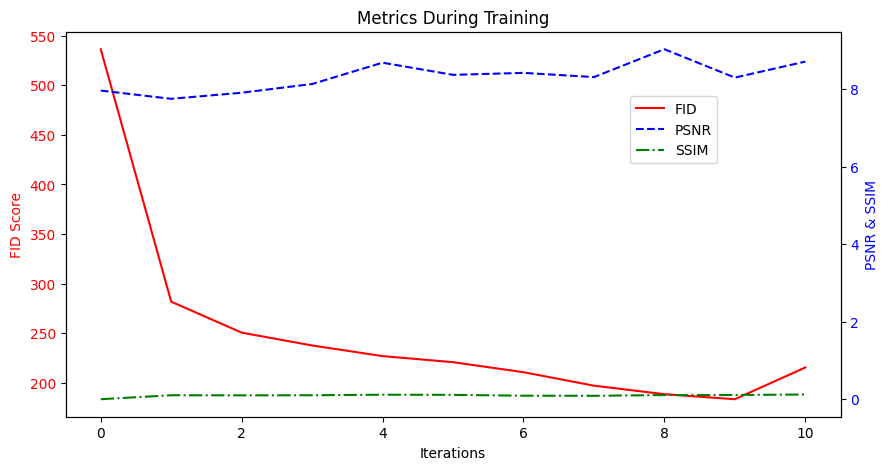

In [ ]:
import matplotlib.pyplot as plt

# Plot FID on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title("Metrics During Training")
ax1.plot(fid_scores, label="FID", color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("FID Score", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create a twin y-axis for PSNR and SSIM
ax2 = ax1.twinx()
ax2.plot(psnr_scores, label="PSNR", color="blue", linestyle="--")
ax2.plot(ssim_scores, label="SSIM", color="green", linestyle="-.")
ax2.set_ylabel("PSNR & SSIM", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both y-axes
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85), bbox_transform=ax1.transAxes)

plt.show()


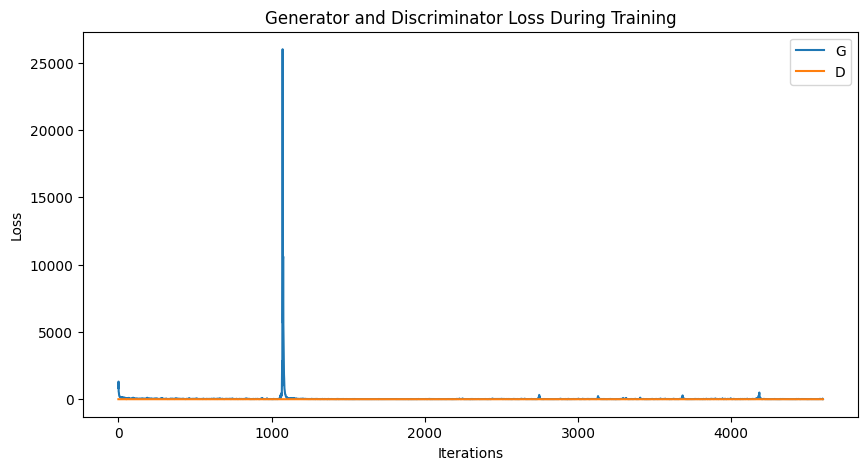

In [ ]:
# Plot Generator and Discriminator Loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


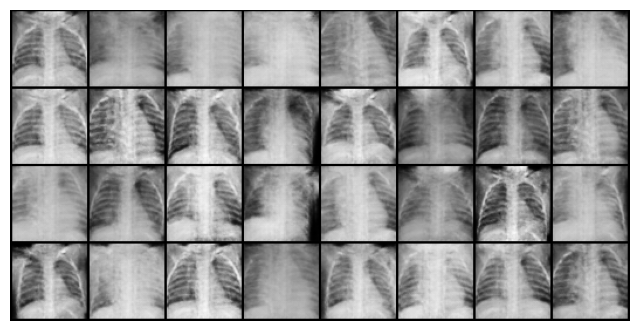

In [ ]:
# Generate and display the animation of generated images
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

